#### 📚 2.1 Import Required Libraries and Set Up Parameters
- **Import Libraries**: Import key libraries such as `geopandas` for geospatial data manipulation, `pandas` for data handling, `shapely` for geometric operations, `scipy` for spatial queries, `networkx` for network analysis, and `os`, `re`, `json` for file operations and data processing.
- **Configure Area and Coordinate System**: Define analysis parameters for the geographic area and coordinate system.

In [2]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString
from scipy.spatial import KDTree
import networkx as nx
import os
import re
import json

# Input variables
area_name = 'Friesland'
coord_system = 28992 # Has to be a coord system with meter as units

# Import all functions needed for the Jupyter notebook

def generate_service_area(roads_gdf, stations_gdf, max_cost, cost_field="length"):
    # Ensure same CRS
    stations_gdf = stations_gdf.to_crs(roads_gdf.crs)

    # Create graph from roads
    G = nx.Graph()
    for idx, row in roads_gdf.iterrows():
        geom = row.geometry
        cost = row[cost_field]

        if isinstance(geom, LineString):
            coords = list(geom.coords)
            for i in range(len(coords) - 1):
                u = tuple(coords[i])
                v = tuple(coords[i + 1])
                segment = LineString([u, v])
                segment_length = segment.length
                segment_cost = cost * (segment_length / geom.length)
                G.add_edge(u, v, weight=segment_cost, geometry=segment, road_id=idx)

    # Snap station points to nearest node in the graph
    nodes = list(G.nodes)
    tree = KDTree(nodes)

    start_nodes = []
    for index, geom in zip(stations_gdf.index, stations_gdf.geometry):
        dist, idx = tree.query((geom.x, geom.y))
        start_nodes.append((index, geom, nodes[idx]))

    # Perform Dijkstra from each origin
    reachable_edges = []
    for index, geom, start in start_nodes:
        lengths, paths = nx.single_source_dijkstra(G, source=start, cutoff=max_cost, weight="weight")
        for path in paths.values():
            for i in range(len(path) - 1):
                u, v = path[i], path[i + 1]
                if G.has_edge(u, v):
                    reachable_edges.append((index, geom, u, v))

    # Build GeoDataFrame of reachable edges
    start_geom = []
    edge_geoms = []
    start_nodes = []
    for start, init_geom, u, v in reachable_edges:
        geom = G[u][v]['geometry']
        start_geom.append(init_geom)
        edge_geoms.append(geom)
        start_nodes.append(start)

    start_nodes_df = pd.DataFrame({"start_nodes": start_nodes, 'init_geom': start_geom})
    service_area_gdf = gpd.GeoDataFrame(start_nodes_df, geometry=edge_geoms, crs=roads_gdf.crs)
    service_area_gdf = service_area_gdf.dissolve('start_nodes')
    service_area_gdf.index.name = None

    return service_area_gdf

def reverse_score(stedelijkheid):
    if stedelijkheid == 1:
        return 5
    if stedelijkheid == 2:
        return 4
    if stedelijkheid == 3:
        return 3
    if stedelijkheid == 4:
        return 2
    if stedelijkheid == 5:
        return 1
    
def extract_routes(lijnen):
    # Remove apostrophes
    lijnen = lijnen.strip("'")
    # Split by comma and space
    lines = lijnen.split(', ')
    # Exclude routes containing 'Stopbus' and extract unique routes
    routes = [route.strip() for line in lines for route in line.split(',') if 'Stopbus' not in route]
    return len(set(routes))

def normalize_stop_name(stop_name):
    # Remove parentheses and their contents
    stop_name = re.sub(r'\(.*\)', '', stop_name)
    # Remove trailing whitespace
    stop_name = stop_name.strip()
    return stop_name

def green_party_votes(vote_list, party_list):
    votes = json.loads(vote_list)
    return sum(item["v"] for item in votes if item["n"] in party_list)

### 🚶‍♂️ 2.2 Walkability
- The indicator <code>walkability</code> provides a score for the service area of the potential location. The service area can also be described as the area from which the location is accessible within a reasonable walking distance. The larger this service area, the higher the score. To calculate walkability, the road and pedestrian network was taken into account, ensuring that only feasible routes were considered. The acceptable walking distance for the service area for the example case of the province of Utrecht was set at 250 meters (Geurs, et al., 2023).

##### 📍 2.2.1 Generate Service Areas Using Road Networks

                                                geometry  \
1158   MULTILINESTRING ((158615.271 575460.332, 15862...   
2570   MULTILINESTRING ((167658.179 545948.631, 16759...   
10211  MULTILINESTRING ((192825.63 552556.636, 192830...   
10858  MULTILINESTRING ((195035.54 583402.655, 195036...   
3913   MULTILINESTRING ((173114.439 580889.902, 17311...   
296    MULTILINESTRING ((152856.922 601537.534, 15286...   
2168   MULTILINESTRING ((165201.73 540502.185, 165200...   
13296  MULTILINESTRING ((200994.47 586589.988, 200977...   
13936  MULTILINESTRING ((202104.821 581322.801, 20200...   
10713  MULTILINESTRING ((195019.041 548208.961, 19513...   

                                          init_geom  
1158    POINT (158629.4743849979 575462.3957808367)  
2570    POINT (167598.5679577549 546016.1668602771)  
10211  POINT (192828.09266555874 552551.4528240473)  
10858  POINT (195036.59133712735 583419.9808951699)  
3913   POINT (173116.49947021308 580894.5621012379)  
296     POINT (

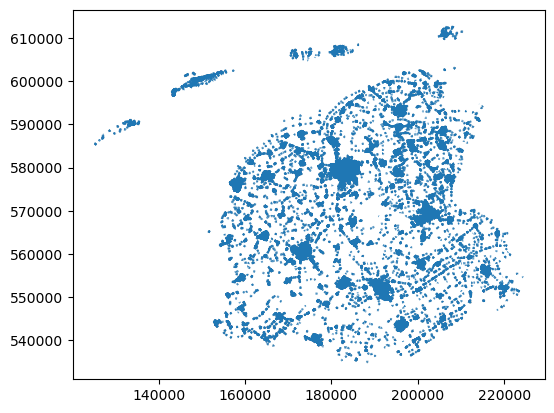

In [ ]:
# https://www.cbs.nl/nl-nl/dossier/nederland-regionaal/geografische-data/wijk-en-buurtkaart-2022

input_file = rf"output/crossroads/crossroads_{area_name}_{coord_system}.gpkg"
output_file = rf"output/walkability/walkability_service_area_{area_name}_{coord_system}.gpkg"
OSM_streets_file = rf"sources/osm_roads_{area_name}/gis_osm_roads_free_1.shp"

roads_gdf = gpd.read_file(OSM_streets_file)
crossroads_gdf = gpd.read_file(input_file, layer='crossroads')

# Ensure it is in Amersfoort coordinate system
roads_gdf = roads_gdf.to_crs(epsg=coord_system)
roads_gdf['length'] = roads_gdf['geometry'].length

# Create a service area from point with a cost of 250 meters
service_area_gdf = generate_service_area(roads_gdf, crossroads_gdf, 250, cost_field="length")

print(service_area_gdf.sample(10))
service_area_gdf.plot()

# Save output
if os.path.exists(output_file):
    os.remove(output_file)

service_area_gdf.to_file(output_file, layer="service_area", driver="GPKG")

##### 📊 2.2.2 Process Road and Crossroad Data

                                          init_geom  \
2746   POINT (167864.08278290933 584446.7873491491)   
15043  POINT (206150.85694404153 543341.8677631826)   
13618    POINT (201640.4587519724 589399.813250177)   
9803   POINT (191434.33479009257 551001.9361046323)   
15436   POINT (207119.0224357508 567450.7757073222)   
6523   POINT (181874.73876831346 580020.7149637868)   
8450   POINT (185735.89041476164 561692.9166584013)   
408     POINT (156215.1081917606 561243.0291907426)   
8009    POINT (184021.1451973769 580120.4575698652)   
16188   POINT (212111.5674394258 559064.0892071372)   

                                                geometry    walkability  
2746   POLYGON ((167944.789 584300.745, 167798.04 584...   26219.630294  
15043  POLYGON ((206064.016 543200.411, 206028.198 54...   90917.487206  
13618  POLYGON ((201702.135 589208.677, 201412.16 589...   57984.229409  
9803   POLYGON ((191391.637 550814.424, 191304.751 55...   96483.046049  
15436  POLYGON ((207146.

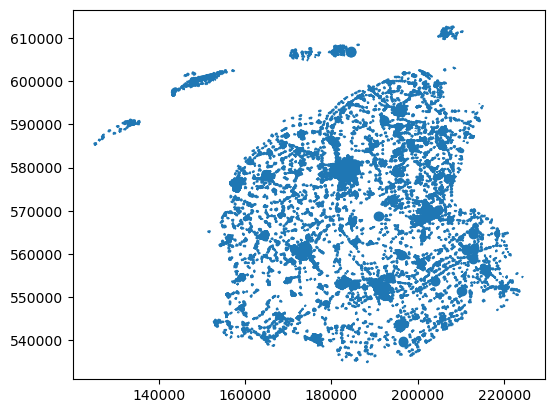

In [ ]:
input_file = rf"output/walkability/walkability_service_area_{area_name}_{coord_system}.gpkg"
output_file = rf"output/walkability/walkability_convex_hull_{area_name}_{coord_system}.gpkg"

service_area_gdf = gpd.read_file(input_file, layer='service_area')

# Create a convex hull from the service area (lines to polygon)
convex_hulls_gdf = service_area_gdf.copy()
convex_hulls_gdf['geometry'] = service_area_gdf['geometry'].convex_hull
# Calculate area of the convex hull
convex_hulls_gdf['walkability'] = convex_hulls_gdf['geometry'].area

print(convex_hulls_gdf.sample(10))
convex_hulls_gdf.boundary.plot()

# Save output
if os.path.exists(output_file):
    os.remove(output_file)

convex_hulls_gdf.to_file(output_file, layer="convex_hull", driver="GPKG", mode="a")

##### 🔄 2.2.3 Calculate Walkability Index with Convex Hulls

         walkability                       geometry
3777    79190.867314  POINT (172873.475 560122.893)
1757    67399.933566  POINT (163888.316 575571.283)
2942    72980.940471  POINT (168646.745 569492.112)
3227    91052.767059   POINT (171687.736 560680.24)
14889  106147.658743  POINT (205163.974 584854.192)
11652   71536.372450  POINT (195855.417 594460.474)
6220    90170.922767    POINT (181532.22 580624.62)
12693   52647.468400   POINT (200027.458 556890.03)
6851   129148.487774  POINT (182431.392 580810.325)
13349   53966.286800  POINT (201481.351 553881.697)


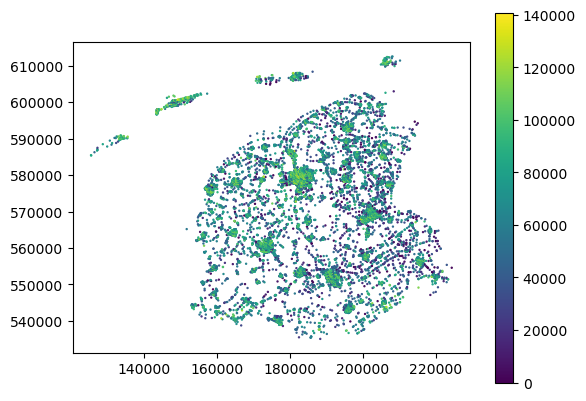

In [ ]:
input_file_convex_hull = rf"output/walkability/walkability_convex_hull_{area_name}_{coord_system}.gpkg"
input_file_crossroads = rf"output/crossroads/crossroads_{area_name}_{coord_system}.gpkg"
output_file = rf"output/walkability/walkability_{area_name}_{coord_system}.gpkg"

convex_hull_gdf = gpd.read_file(input_file_convex_hull)

# Merge convex hulls GeoDataFrame to the original GeoDataFrame
convex_hull_gdf['init_geom'] = gpd.GeoSeries.from_wkt(convex_hull_gdf['init_geom'])
walkability_gdf = gpd.GeoDataFrame(convex_hull_gdf['walkability'], geometry=convex_hull_gdf['init_geom'], crs=convex_hulls_gdf.crs)

print(walkability_gdf.sample(10))
walkability_gdf.plot(column="walkability", markersize=0.5, legend=True)

# Save output
if os.path.exists(output_file):
    os.remove(output_file)

walkability_gdf.to_file(output_file, layer="walkability", driver="GPKG", mode="a")

#### 🚸 2.3 Urbanization
- The <code>urbanization</code> indicator provides a score for the number of addresses per square kilometre at each potential location, also known as address density. Address density is closely related to population density, so in the absence of data on address density, population density data can also be used. The address (or population) density influences the number of potential users near the potential location.

                            geometry  urban
12136  POINT (197764.309 585935.258)    2.0
9602   POINT (190511.754 553073.156)    4.0
9811   POINT (192089.387 551115.838)    2.0
5751   POINT (180626.875 579089.721)    3.0
1670   POINT (164141.449 564075.215)    4.0
15062  POINT (206243.442 544756.939)    1.0
15109    POINT (206066.889 556100.3)    1.0
4290   POINT (173703.382 580977.628)    1.0
648    POINT (158261.561 555969.296)    1.0
13551   POINT (201762.51 572300.214)    1.0


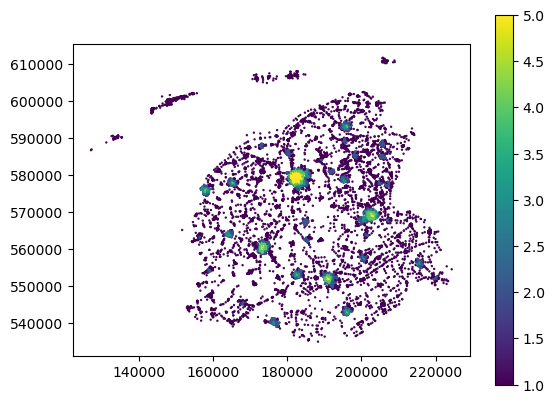

In [ ]:
# https://www.cbs.nl/nl-nl/dossier/nederland-regionaal/geografische-data/gegevens-per-postcode

input_file_crossroads = rf"output/crossroads/crossroads_{area_name}_{coord_system}.gpkg"
input_file_urbanization = r"sources/cbs_vk500_2023_v1.gpkg"
output_file = rf"output/urbanization/urbanization_{area_name}_{coord_system}.gpkg"

crossroads_gdf = gpd.read_file(input_file_crossroads, layer='crossroads')
urbanization_gdf = gpd.read_file(input_file_urbanization, layer='cbs_vk500_2023', columns=['stedelijkheid'])

# Left join the urbanization data to the crossroads GeoDataFrame
urbanization_crossroads_gdf = crossroads_gdf.sjoin(urbanization_gdf, how='left', predicate='intersects')

# Reverse the scores, as in the original data the highest urbanization gets the lowest score
urbanization_crossroads_gdf['urban'] = urbanization_crossroads_gdf['stedelijkheid'].apply(lambda x: reverse_score(x))

# Drop redundant columns
urbanization_crossroads_gdf = urbanization_crossroads_gdf.drop(columns=['index_right', 'stedelijkheid'])

print(urbanization_crossroads_gdf.sample(10))
urbanization_crossroads_gdf.plot(column="urban", markersize=0.5, legend=True)

# Save output
if os.path.exists(output_file):
    os.remove(output_file)

urbanization_crossroads_gdf.to_file(output_file, layer="urbanization", driver="GPKG", mode="a")

#### 🚗 2.4 Cars per household
- The number of <code>cars per household</code> can have an influence on the usage of (shared) cargo bikes. Households with a higher number of cars are less likely to use shared cargo bike services as they already have alternative modes of transportation for moving goods and people. The score for this indicator depends on the average number of cars per household in the area of the potential location. It is important to invert the score in the last step, as higher car ownership is associated with lower potential for shared cargo bike service usage.

                            geometry  car_ownership
10515  POINT (193656.868 568964.611)            1.3
7027   POINT (182478.109 578882.401)            0.7
12817  POINT (199799.731 569922.059)            2.4
12208   POINT (196969.53 593517.441)            1.0
9628   POINT (191006.175 553330.745)            1.1
14256  POINT (203479.951 576128.273)            1.5
10987   POINT (195347.859 593701.84)            1.0
9537    POINT (190520.302 552240.24)            1.0
12957  POINT (199541.223 599367.082)            1.4
929    POINT (159439.884 547268.121)            1.2


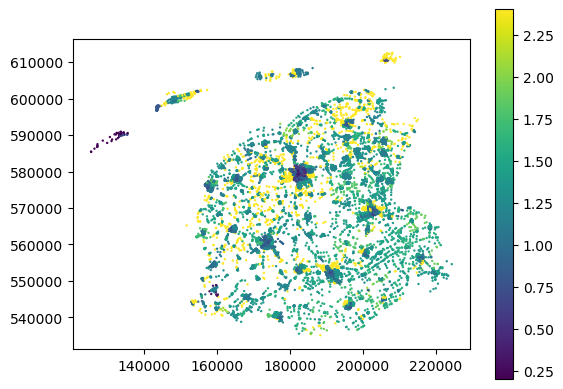

In [ ]:
# https://www.cbs.nl/nl-nl/dossier/nederland-regionaal/geografische-data/wijk-en-buurtkaart-2022

input_file_crossroads = rf"output/crossroads/crossroads_{area_name}_{coord_system}.gpkg"
input_file_car_ownership = r"sources/wijkenbuurten_2024_v1.gpkg"
output_file = rf"output/car_ownership/car_ownership_{area_name}_{coord_system}.gpkg"

crossroads_gdf = gpd.read_file(input_file_crossroads, layer='crossroads')
car_ownership_gdf = gpd.read_file(input_file_car_ownership, layer='neighborhood', columns=['personenautos_per_huishouden'])

# Left join the car ownership data to the crossroads GeoDataFrame
car_ownership_crossroads_gdf = crossroads_gdf.sjoin(car_ownership_gdf, how='left', predicate='intersects')
car_ownership_crossroads_gdf = car_ownership_crossroads_gdf.drop(columns=['index_right'])

# Replace null values with max score (max penalty), as null values are usually in areas with no inhabitants
car_ownership_crossroads_gdf['personenautos_per_huishouden'] = car_ownership_crossroads_gdf['personenautos_per_huishouden'].replace(-99997.0, car_ownership_crossroads_gdf['personenautos_per_huishouden'].max())
car_ownership_crossroads_gdf = car_ownership_crossroads_gdf.rename(columns={"personenautos_per_huishouden": "car_ownership"})

print(car_ownership_crossroads_gdf.sample(10))
car_ownership_crossroads_gdf.plot(column="car_ownership", markersize=0.5, legend=True)

# Save output
if os.path.exists(output_file):
    os.remove(output_file)

car_ownership_crossroads_gdf.to_file(output_file, layer="car_ownership", driver="GPKG", mode="a")

#### 🏠 2.5 Households with childrens
- <code>Households with children</code> are associated with higher levels of shared cargo bike usage, since these bikes are often used for moving children. Therefore the indicator ‘households with children’ provides a score for the percentage of households with children in the area of the potential location. Note: If you are not able to calculate the walkability, a buffer can also be used instead.

                            geometry  children_household
1176    POINT (158694.76 575908.566)                  40
3782   POINT (172941.531 560143.804)                  27
15696  POINT (207219.123 586332.622)                  44
1621    POINT (164408.68 563708.099)                  30
12691  POINT (199581.138 553434.175)                  27
1371   POINT (160170.252 568039.937)                  30
8687   POINT (185458.135 580281.877)                  29
11423  POINT (195948.279 564902.052)                  39
8604   POINT (185297.418 576511.714)                  69
16017  POINT (210763.969 590293.441)                  31


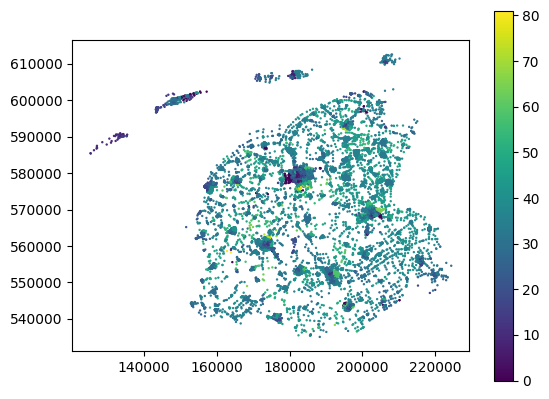

In [4]:
# https://www.cbs.nl/nl-nl/dossier/nederland-regionaal/geografische-data/gegevens-per-postcode

input_file_crossroads = rf"output/crossroads/crossroads_{area_name}_{coord_system}.gpkg"
input_file_children = r"sources/wijkenbuurten_2024_v1.gpkg"
output_file = rf"output/children_household/children_household_{area_name}_{coord_system}.gpkg"

crossroads_gdf = gpd.read_file(input_file_crossroads, layer='crossroads')
children_gdf = gpd.read_file(input_file_children, layer='buurten', columns=['percentage_huishoudens_met_kinderen'])

# Left join the children per household data to the crossroads GeoDataFrame
children_crossroads_gdf = crossroads_gdf.sjoin(children_gdf, how='left', predicate='within')
children_crossroads_gdf = children_crossroads_gdf.drop(columns=['index_right'])

# Replace null values with min score (max penalty), as null values are usually in areas with no inhabitants
children_crossroads_gdf['percentage_huishoudens_met_kinderen'] = children_crossroads_gdf['percentage_huishoudens_met_kinderen'].replace(-99997.0, 9999)
children_crossroads_gdf['percentage_huishoudens_met_kinderen'] = children_crossroads_gdf['percentage_huishoudens_met_kinderen'].replace(9999, children_crossroads_gdf['percentage_huishoudens_met_kinderen'].min())
children_crossroads_gdf = children_crossroads_gdf.rename(columns={"percentage_huishoudens_met_kinderen": "children_household"})

print(children_crossroads_gdf.sample(10))
children_crossroads_gdf.plot(column="children_household", markersize=0.5, legend=True)

# Save output
if os.path.exists(output_file):
    os.remove(output_file)

children_crossroads_gdf.to_file(output_file, layer="children_household", driver="GPKG", mode="a")

#### 👶 2.6 Age Demographic
- The indicator <code>age</code> provides a score based on the age-groups that live in the area of the location. In the literature, it is found that shared mobility use is mostly used by age groups between 18 and 45 and parents of young children, which was also confirmed during the expert-workshop. For the analysis, the statistics of the area of the potential location is used to calculate a score.

                            geometry    age
9155   POINT (189212.134 553205.407)  0.115
11073  POINT (195571.865 559970.477)  0.435
8881   POINT (187916.432 556618.915)  0.430
10234   POINT (192224.459 553141.55)  0.460
16269   POINT (213952.06 565364.041)  0.440
12801  POINT (200163.885 568255.201)  0.255
7404    POINT (182784.65 580534.966)  0.545
4831   POINT (176307.892 540952.305)  0.415
10865  POINT (194773.449 583549.604)  0.380
6859   POINT (182369.145 581081.221)  0.415


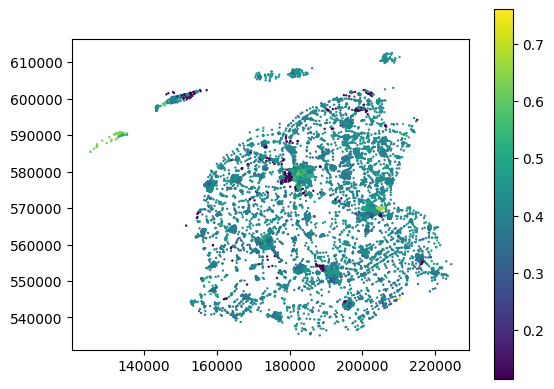

In [ ]:
# https://www.cbs.nl/nl-nl/dossier/nederland-regionaal/geografische-data/gegevens-per-postcode

input_file_crossroads = rf"output/crossroads/crossroads_{area_name}_{coord_system}.gpkg"
input_file_age = r"sources/wijkenbuurten_2024_v1.gpkg"
output_file = rf"output/age/age_{area_name}_{coord_system}.gpkg"

crossroads_gdf = gpd.read_file(input_file_crossroads, layer='crossroads')
age_gdf = gpd.read_file(input_file_age, layer='buurten', columns=['percentage_personen_0_tot_15_jaar', 'percentage_personen_15_tot_25_jaar', 'percentage_personen_25_tot_45_jaar', 'percentage_personen_45_tot_65_jaar', 'percentage_personen_65_jaar_en_ouder'])

# Left join the age data to the crossroads GeoDataFrame
age_crossroads_gdf = crossroads_gdf.sjoin(age_gdf, how='left', predicate='intersects')

# Make an age score based on the ages most associated with shared mobility usage, with 25 to 45 getting the highest importance
age_crossroads_gdf['age'] = age_crossroads_gdf['percentage_personen_15_tot_25_jaar']/100 * 0.5 + age_crossroads_gdf['percentage_personen_25_tot_45_jaar']/100 + age_crossroads_gdf['percentage_personen_45_tot_65_jaar']/100 * 0.5
age_crossroads_gdf['age'] = age_crossroads_gdf['age'].replace(-1999.940, 9999)
age_crossroads_gdf['age'] = age_crossroads_gdf['age'].replace(9999, age_crossroads_gdf['age'].min())

# Drop redundant columns
age_crossroads_gdf = age_crossroads_gdf.drop(columns=['index_right', 'percentage_personen_0_tot_15_jaar', 'percentage_personen_15_tot_25_jaar', 'percentage_personen_25_tot_45_jaar', 'percentage_personen_45_tot_65_jaar', 'percentage_personen_65_jaar_en_ouder'])

print(age_crossroads_gdf.sample(10))
age_crossroads_gdf.plot(column="age", markersize=0.5, legend=True)

# Save output
if os.path.exists(output_file):
    os.remove(output_file)

age_crossroads_gdf.to_file(output_file, layer="age", driver="GPKG", mode="a")

#### 🎓 2.7 Educational Level
- The use of shared-mobility services is more prevalent among people with higher <code>education levels</code>. This has been described in both the literature as well as during the expert workshop. Therefore this indicator has a score based on the percentage of highly educated residents in the area of the potential location.

                            geometry  education
2913    POINT (170252.19 567656.659)   0.229299
9175   POINT (188824.709 554000.577)   0.000000
10179  POINT (192465.441 551942.794)   0.356061
12175   POINT (197841.225 589873.96)   0.163934
15311  POINT (206427.418 589384.345)   0.218750
11713  POINT (196230.068 543455.465)   0.115556
2469   POINT (167869.044 541967.587)   0.178571
15076  POINT (205894.986 545056.886)   0.070796
1769   POINT (164349.538 577278.078)   0.000000
14110  POINT (202989.032 569003.481)   0.000000


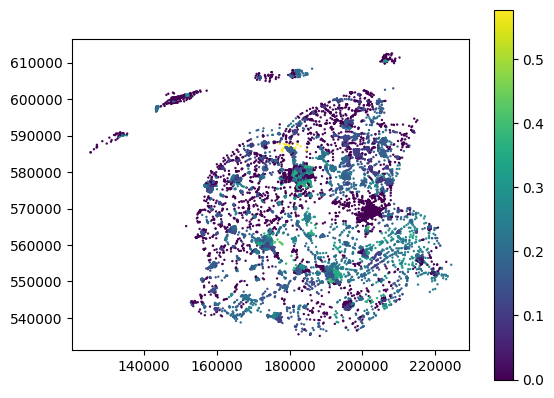

In [ ]:
# https://opendata.cbs.nl/portal.html?_la=nl&_catalog=CBS&tableId=86052NED&_theme=377 Onbewerkte dataset: Onderwerpen: Regiocode, Bevolking 15 tot 75 jaar, opleidingsniveau 3 HBO, wo, Marges: Waarde, Wijken en buurten: alles

input_file_crossroads = rf"output/crossroads/crossroads_{area_name}_{coord_system}.gpkg"
input_file_education = r"sources/86052NED_UntypedDataSet_17042025_093410.csv" 
input_file_neighborhood = r"sources/wijkenbuurten_2024_v1.gpkg"
output_file = rf"output/education/education_{area_name}_{coord_system}.gpkg"

# Load and read the csv
crossroads_gdf = gpd.read_file(input_file_crossroads, layer='crossroads')
education_df = pd.read_csv(input_file_education, sep=';', usecols=['WijkenEnBuurten','Bevolking15Tot75Jaar_2'])
# Create DataFrame from csv
education_df = education_df.rename(columns={"Bevolking15Tot75Jaar_2":"a_hoog_opl"})
# Remove blank spaces from file
education_df['a_hoog_opl'] = education_df['a_hoog_opl'].str.strip()
# '.' is a null value in this file. Replace it with a numerical null value for type consistency
education_df['a_hoog_opl'] = education_df['a_hoog_opl'].replace(".",-9999)
education_df = education_df.astype({"a_hoog_opl":"int"})
neighborhood_gdf = gpd.read_file(input_file_neighborhood, layer='buurten', columns=['buurtcode','aantal_inwoners'])

# Join the education table with neighbourhoods GeoDataFrame to make it spatial
education_neighborhood_gdf = neighborhood_gdf.merge(education_df, left_on='buurtcode', right_on='WijkenEnBuurten')
education_neighborhood_gdf = education_neighborhood_gdf.drop(columns=['WijkenEnBuurten'])

# Left join the education data to the crossroads GeoDataFrame
education_neighborhood_crossroads_gdf = crossroads_gdf.sjoin(education_neighborhood_gdf, how='left', predicate='intersects')
# Fill gaps with null values
education_neighborhood_crossroads_gdf = education_neighborhood_crossroads_gdf.fillna(-9999) 

# If neighborhood has no inhabitants, also apply null value
education_neighborhood_crossroads_gdf['aantal_inwoners'] = education_neighborhood_crossroads_gdf['aantal_inwoners'].replace(0,-9999)
# Calculate percentage of higher educated from absolute value
education_neighborhood_crossroads_gdf['p_hoog_opl'] = education_neighborhood_crossroads_gdf['a_hoog_opl'] / education_neighborhood_crossroads_gdf['aantal_inwoners']

# Replace null values with lowest score (max penalty)
education_neighborhood_crossroads_gdf.loc[education_neighborhood_crossroads_gdf['aantal_inwoners'] == -9999, 'p_hoog_opl'] = 0
education_neighborhood_crossroads_gdf.loc[education_neighborhood_crossroads_gdf['a_hoog_opl'] == -9999, 'p_hoog_opl'] = 0

# Some values are above 1, which is an impossibe ratio
education_neighborhood_crossroads_gdf.loc[education_neighborhood_crossroads_gdf['p_hoog_opl'] > 1, 'p_hoog_opl'] = 0

# Drop redundant columns and rename for clarity
education_neighborhood_crossroads_gdf = education_neighborhood_crossroads_gdf.drop(columns=['index_right', 'aantal_inwoners', 'buurtcode', 'a_hoog_opl'])
education_neighborhood_crossroads_gdf = education_neighborhood_crossroads_gdf.rename(columns={"p_hoog_opl": "education"})

print(education_neighborhood_crossroads_gdf.sample(10))
education_neighborhood_crossroads_gdf.plot(column="education", markersize=0.5, legend=True)

# Save output
if os.path.exists(output_file):
    os.remove(output_file)

education_neighborhood_crossroads_gdf.to_file(output_file, layer="education", driver="GPKG", mode="a")

#### 🚉 2.8 Analyze Public Transport Accessibility
- The <code>Public transport</code> indicator provides a score based on the number of train-, bus- and other public transportation lines departing within the service area of the location. The connection between shared mobility services and public transportation remains underexplored in the literature. However, in the expert-workshop, a preference for public-transport stops was mentioned and it is assumed that a higher number of available public transportation lines within walking distance enhances the connection between shared mobility and the public transport network.
##### 🚏 2.8.1 Analyze all Public Transport Stops

                normalized_stop_name                       geometry  \
12409           Maarn, Ted Visserweg  POINT (153434.025 453048.045)   
17241     Schinveld, Mariabergstraat  POINT (196864.966 330723.976)   
5765          Dordrecht, Kometenlaan  POINT (105661.015 422140.952)   
6235          Eelde, Henri Dunantweg   POINT (233768.01 573415.994)   
16398  Rotterdam, Bergse Dorpsstraat   POINT (93654.991 441561.051)   
7517            Geleen, Kerenshofweg  POINT (185282.023 330108.958)   
13402              Monster, Papelaan   POINT (73032.996 448014.013)   
6038               Dudzele, Pelikaan    POINT (7631.969 370052.011)   
13635                 Nes, Zwarteweg  POINT (181497.983 607708.952)   
8703           Harlingen, De Batting  POINT (157686.972 575101.988)   

       unique_routes  
12409              4  
17241              1  
5765               6  
6235               2  
16398              9  
7517               9  
13402              3  
6038               4  
13635      

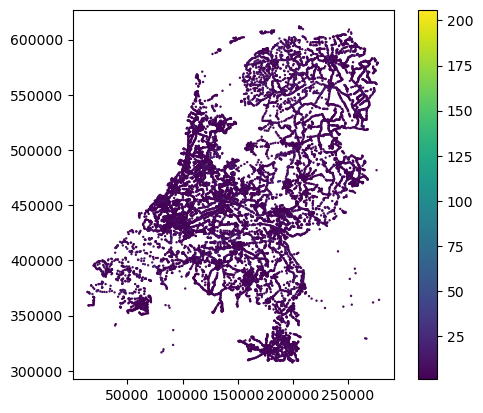

In [ ]:
# From https://hub.arcgis.com/maps/9c7f791fb35e4eaab465e342fdf944e1/about layer: haltes

input_file_PT = r"sources/Haltes/Haltes.shp"
output_file = fr"output/public_transport/public_transport_stops_{area_name}_{coord_system}.gpkg"

PT_gdf = gpd.read_file(input_file_PT)
PT_gdf = PT_gdf.to_crs(coord_system)

# Apply the function to create the new column
PT_gdf['unique_routes'] = PT_gdf['lijnen'].apply(extract_routes)

# Apply the function to create the 'normalized_stop_name' column. I.e. all stops with the same name are merged
PT_gdf['normalized_stop_name'] = PT_gdf['stop_name'].apply(normalize_stop_name)

# Group by 'normalized_stop_name' and make a sum of all the unique PT lines servicing this stop
PT_grouped_gdf = PT_gdf.groupby('normalized_stop_name').agg({'geometry':'first', 'stop_name':'first', 'unique_routes':'sum'}).reset_index()
# Correct geometry column that has been removed by the 'groupby' function
PT_grouped_gdf = gpd.GeoDataFrame(PT_grouped_gdf, geometry='geometry', crs=PT_gdf.crs)

# Drop redundant columns
PT_grouped_gdf = PT_grouped_gdf.drop(columns=['stop_name'])

#Clip before plotting
PT_grouped_gdf_clip = gpd.clip(PT_grouped_gdf, (13590, 306846, 278024, 619241))

# Display the DataFrame with the new column
print(PT_grouped_gdf.sample(10))
PT_grouped_gdf_clip.plot(column="unique_routes", markersize=0.5, legend=True)

# Save to file
if os.path.exists(output_file):
    os.remove(output_file)

PT_grouped_gdf.to_file(output_file, layer="PT_stops", driver="GPKG", mode="a")

##### 🚏 2.8.2 Public Transport accessibility at the crossroad

                            geometry  public_transport
1434    POINT (160932.612 571488.11)               6.0
13126   POINT (201205.12 563822.807)               0.0
14056   POINT (202996.881 568419.76)               0.0
5263   POINT (177856.485 577260.441)               0.0
10954  POINT (195043.276 592967.533)               0.0
12920   POINT (199470.839 588928.43)               0.0
13359  POINT (201502.031 556517.632)               0.0
7377   POINT (183047.565 580165.978)              15.0
7083    POINT (182736.866 580235.07)               0.0
12924  POINT (199715.456 590385.157)               4.0


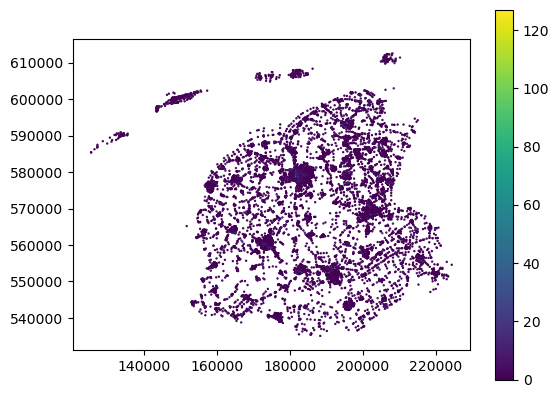

In [ ]:
input_file_convex_hull = fr"output/walkability/walkability_convex_hull_{area_name}_{coord_system}.gpkg"
input_file_PT_stops = fr"output/public_transport/public_transport_stops_NL_28992.gpkg"
input_file_crossroads = fr"output/crossroads/crossroads_{area_name}_{coord_system}.gpkg"
output_file = fr"output/public_transport/public_transport_{area_name}_{coord_system}.gpkg"

convex_hull_gdf = gpd.read_file(input_file_convex_hull, layer='convex_hull')
PT_stops_gdf = gpd.read_file(input_file_PT_stops, layer='PT_stops')
crossroads_gdf = gpd.read_file(input_file_crossroads, layer='crossroads')

# Take the convex hull of 250 meter as the service area of the PT stop
convex_hull_PT_stops_gdf = convex_hull_gdf.sjoin(PT_stops_gdf, how='left', predicate='intersects')
convex_hull_PT_stops_gdf = convex_hull_PT_stops_gdf.drop(columns=['index_right'])

# Sort by number of unique routes
convex_hull_PT_stops_gdf = convex_hull_PT_stops_gdf.sort_values(by='unique_routes', ascending=False)
# Select the PT stop within the service area with the largest number of routes
# The logic is that PT routes close to each other often service the same routes
convex_hull_PT_stops_gdf = convex_hull_PT_stops_gdf.drop_duplicates(subset='init_geom', keep="first")
# Fill service areas with no PT routes
convex_hull_PT_stops_gdf['unique_routes'] = convex_hull_PT_stops_gdf['unique_routes'].fillna(0)

# Left join the PT stops data to the crossroads GeoDataFrame
crossroads_PT_stops_gdf = crossroads_gdf.merge(convex_hull_PT_stops_gdf[['init_geom','unique_routes']], how='left', left_index=True, right_index=True)
crossroads_PT_stops_gdf = gpd.sjoin(crossroads_gdf, crossroads_PT_stops_gdf, how='left')
crossroads_PT_stops_gdf = crossroads_PT_stops_gdf.fillna(0)

# Drop redundant columns and rename for clarity
crossroads_PT_stops_gdf = crossroads_PT_stops_gdf.drop(columns=['init_geom', 'index_right'])
crossroads_PT_stops_gdf = crossroads_PT_stops_gdf.rename(columns={'unique_routes':'public_transport'})

print(crossroads_PT_stops_gdf.sample(10))
crossroads_PT_stops_gdf.plot(column='public_transport', markersize=0.5, legend=True)

# Save output
if os.path.exists(output_file):
    os.remove(output_file)

crossroads_PT_stops_gdf.to_file(output_file, layer="public_transport", driver="GPKG", mode="a")

#### 🌳 2.9 Green Ideals with Voting Data
- Demographics groups with <code>green ideals</code> have been associated with higher usage of carsharing. The assumption has been made that this group is also more inclined to use shared cargo bike services when they are offered. Green ideals at a location can be quantified by using data on election results in the area surrounding the potential location.

Skipping field new: unsupported OGR type: 3


                            geometry  green_ideals
8176   POINT (184955.481 562706.503)      0.246753
9470   POINT (190102.516 551557.972)      0.212316
1829   POINT (163113.219 582956.064)      0.094118
6298      POINT (181519.21 591176.4)      0.126382
5036   POINT (176215.025 605571.208)      0.195341
4919   POINT (175818.757 558215.866)      0.125356
3498    POINT (172544.53 560047.996)      0.130178
8199   POINT (184691.216 566587.031)      0.227535
16308  POINT (213269.106 566800.298)      0.171970
14734   POINT (205175.978 546081.82)      0.135729


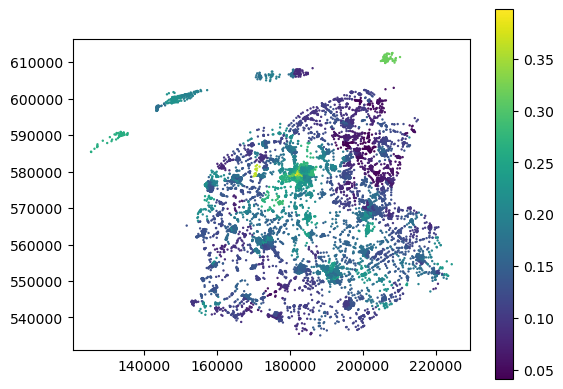

In [ ]:
# https://www.kiesraad.nl/verkiezingen/europees-parlement/uitslagen/uitslagen-per-gemeente

political_parties = {
    1: 'PVV',
    2: 'GL-PvdA',
    3: 'VVD',
    4: 'NSC',
    5: 'D66',
    6: 'BBB',
    7: 'CDA',
    8: 'SP',
    9: 'DENK',
    10: 'PvdD',
    11: 'FvD',
    12: 'SGP',
    13: 'CU',
    14: 'Volt',
    15: 'JA21',
    16: 'BVNL',
    17: '50PLUS',
    18: 'BIJ1',
    19: 'Splinter',
    20: 'Piraten',
    21: 'PLAN',
    22: 'SAMEN',
    23: 'LEF',
    24: 'LP',
    25: 'PartijvdSport',
    26: 'Politieke Partij voor Basisinkomen'
}

input_url_votes_geojson = r"https://www.volkskrant.nl/kijkverder/v/2023/hoe-stemde-uw-buurt-bij-de-verkiezingen-voor-de-tweede-kamer~v960693/media/03963034c3d4c3cf3205c599ffb0ec4a.geojson"
input_file_crossroads = rf"output/crossroads/crossroads_{area_name}_{coord_system}.gpkg"
output_file = fr"output/green_ideals/green_ideals_{area_name}_{coord_system}.gpkg"

votes_gdf = gpd.read_file(input_url_votes_geojson)
votes_gdf = votes_gdf.to_crs(coord_system)
crossroads_gdf = gpd.read_file(input_file_crossroads)

# Save the numbers of votes for the parties 2 and 10 (GroenLinks/PvdA, PvdD) most associated with green ideals
votes_gdf['n_green_votes'] = votes_gdf['p'].apply(green_party_votes, party_list=[2, 10])

# Calculate relative votes instead of absolute
votes_gdf['p_green_votes'] = votes_gdf['n_green_votes'] / votes_gdf['s']

# Join voting booth to closest crossroad
votes_crossroads_gdf = gpd.sjoin_nearest(crossroads_gdf, votes_gdf, how='left')
votes_crossroads_gdf = votes_crossroads_gdf.drop_duplicates(['geometry'])

# Drop redundant columns and rename for clarity
votes_crossroads_gdf = votes_crossroads_gdf.drop(columns=['index_right', 'id', 'd', 'g', 't', 's', 'o', 'b', 'm', 'p', 'cluster', 'n_green_votes'])
votes_crossroads_gdf = votes_crossroads_gdf.rename(columns={'p_green_votes': 'green_ideals'})

print(votes_crossroads_gdf.sample(10))
votes_crossroads_gdf.plot(column='green_ideals', markersize=0.5, legend=True)

# Save output
if os.path.exists(output_file):
    os.remove(output_file)

votes_crossroads_gdf.to_file(output_file, layer="green_ideals", driver="GPKG", mode="a")

#### 🏢 2.10 Points of Interest (POI)
- The <code>Points of Interest</code> (POI) indicator provides a score based on the number of destinations the users are likely to visit within the service area of the potential location. These locations could be stores, offices, schools, sport-facilities and so forth. It is assumed that more POIs in the service area of the location make the location more attractive.

       POIs                       geometry
16491     6  POINT (216313.007 554756.172)
15054     3  POINT (206086.084 544746.974)
13334     3  POINT (201570.308 541216.284)
15681     1  POINT (206945.218 584032.169)
11401     0  POINT (196086.701 550171.916)
12566     0  POINT (198645.433 596725.893)
2253      0  POINT (165189.961 568431.847)
14210     3  POINT (202949.955 570420.712)
11953     2   POINT (196701.34 601708.694)
250      13  POINT (148951.372 600547.876)


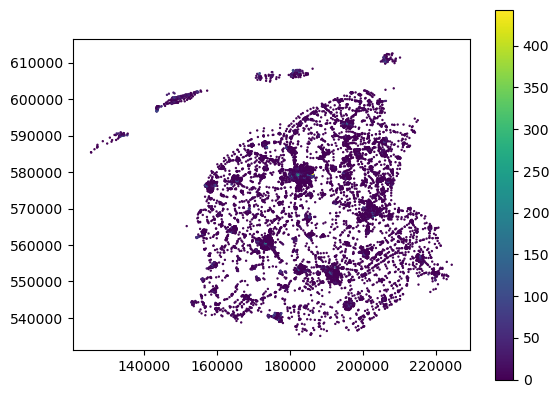

In [ ]:
# https://www.pdok.nl/introductie/-/article/basisregistratie-adressen-en-gebouwen-ba-1

input_file_bag = r"D:/gis_files/vector/bag/bag-light.gpkg"
input_file_convex_hull = fr"output/walkability/walkability_convex_hull_{area_name}_{coord_system}.gpkg"
output_file = fr"output/POIs/POIs_{area_name}_{coord_system}.gpkg"

convex_hull_gdf = gpd.read_file(input_file_convex_hull, layer='convex_hull')
bag_gdf = gpd.read_file(input_file_bag, columns=['gebruiksdoel'], layer='verblijfsobject')

# Functions to remove from the BAG POI list
rm_bag_function_list = ['woonfunctie', 'overige gebruiksfunctie', 'woonfunctie,kantoorfunctie', 'overige gebruiksfunctie,woonfunctie']

# Keep all other functions
bag_gdf = bag_gdf[~bag_gdf['gebruiksdoel'].isin(rm_bag_function_list)]

# Left join the bag to the service area of crossroads GeoDataFrame
bag_convex_hull_gdf = gpd.sjoin(bag_gdf, convex_hull_gdf, how='left', predicate='within')

# Count POIs in service area
point_counts = bag_convex_hull_gdf.groupby('index_right').size()

# Add to GeoDataFrame
convex_hull_gdf['POIs'] = convex_hull_gdf.index.map(point_counts).fillna(0).astype(int)

# Add original point data to service area polygon data
convex_hull_gdf['init_geom'] = gpd.GeoSeries.from_wkt(convex_hull_gdf['init_geom'])

# Create POIS GeoDataFrame from service area and POIs
POIs_gdf = gpd.GeoDataFrame(convex_hull_gdf['POIs'], geometry=convex_hull_gdf['init_geom'], crs=convex_hull_gdf.crs)

print(POIs_gdf.sample(10))
POIs_gdf.plot(column='POIs', markersize=0.5, legend=True)

# Save output
if os.path.exists(output_file):
    os.remove(output_file)

POIs_gdf.to_file(output_file, layer="POIs", driver="GPKG", mode="a")